In [1]:
import os
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.siren as siren

import warnings
warnings.filterwarnings("ignore")

C:\Users\alex\AppData\Local\Temp\ipykernel_18856\2243493270.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def initial_condition(x):
    return np.sin(np.pi * x)

def analytical_solution(x, t, alpha, L):
    sum_terms = 0
    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition(x) * np.sin(n * np.pi * x / L), 0, L)
        sum_terms += 2 / L * B_n * np.sin(n * np.pi * x / L) * np.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return sum_terms

In [3]:
size = 1.0
time = 0.5
alpha = 0.5
N = 100
dx = size / (N - 1)

# Number of points in initial conditions
initial_points = N

# Generate initial conditions
initial_conditions = conditions.set_initial_conditions(lambda x: torch.sin(torch.pi * torch.tensor(x, dtype=torch.float32)).clone().detach(),
                                                       size,
                                                       initial_points,
                                                       dx)

# Number of points in boundary conditions
boundary_points = N

# Generate boundary conditions
boundary_conditions = conditions.set_boundary_conditions(size, 
                                                         boundary_points, 
                                                         time)

# Number of points in equation
equation_points = N

# Generate equation
equation = conditions.set_equation(size, equation_points, time, dx)

In [4]:
def make_plot(x, u_analytical, u_pinn, output_folder, title):
    plt.figure(figsize=(8, 6))
    plt.plot(x, u_analytical, label='Analytical')
    plt.plot(x, u_pinn, label='PINN')
    plt.xlabel('x')
    plt.ylabel('temperature')
    plt.legend()
    plt.title(title)
    plt.savefig(os.path.join(output_folder, title + '.png'))
    # plt.show()

def make_loss_history_plot(data_path, output_folder, title):
    loss_history = pd.read_csv(data_path, header=None)
    plt.plot(loss_history[0], loss_history[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(os.path.join(output_folder, title + '_loss' + '.png'))
    # plt.show()

In [ ]:
hidden_layers = np.array([1, 2, 4, 6, 8, 10, 12, 15])
activations = [nn.Tanh(), nn.ReLU(), nn.ELU(), nn.Sigmoid(), "sin"]
neurons_in_layer = np.array([1, 2, 4, 8, 16, 32, 64])

weights_dir = 'weights'
utils.create_or_clear_folder(weights_dir)

logs_dir = 'logs'
utils.create_or_clear_folder(logs_dir)

l2_norms = {}
for activation in activations:
    for hidden_layer in hidden_layers:
        for neurons in neurons_in_layer:
            mesh_params = pinn.MeshParams(size = size,
                              time = time,
                              alpha = alpha,
                              initial_points = initial_points, 
                              boundary_points = boundary_points, 
                              equation_points = equation_points)

            if activation == "sin":
                siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                            hidden_omega_0 = 30.0,
                                            outermost_linear = True)
            else:
                siren_params = None

            net_params = pinn.NetParams(input = 2,
                                        output = 1,
                                        hidden_layers = [int(neurons) for _ in range(int(hidden_layer))],
                                        activation = activation,
                                        training_mode = 'full',
                                        optimizer = 'Adam',
                                        siren_params = siren_params)

            model = pinn.PINN(mesh_params, net_params, initial_conditions, boundary_conditions, equation, device='cuda:0')
            model.train()

            test = conditions.set_test(mesh_params.size, 100, mesh_params.time)
            u_pinn = model.predict(test.x, test.t).cpu().detach().numpy()

            u_analytical = analytical_solution(test.x.cpu().detach().numpy(), mesh_params.time, alpha, mesh_params.size)

            title = f'model_{len(net_params.hidden_layers)}_{net_params.hidden_layers[0]}_{net_params.activation}'
            # Plot of solution
            make_plot(test.x.cpu().detach().numpy(), u_analytical, u_pinn, model.output_folder, title)
            # Plot loss
            make_loss_history_plot(model.get_loss_history(), model.output_folder, title)

            l2_norm = np.sqrt(np.sum((u_analytical - u_pinn)**2) / len(u_analytical))
            l2_norms[(activation, hidden_layer, neurons)] = l2_norm

            torch.save(model.net.state_dict(), 
                       os.path.join(weights_dir, f'model_{hidden_layer}_{activation}_{neurons}.pt'))

In [9]:
import csv

# Путь к файлу CSV
csv_file_path = 'l2_norms.csv'

# Сохранение данных в CSV файл
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    csv_writer.writerow(['Activation', 'Hidden Layers', 'Neurons', 'L2_norm'])
    
    for key, value in l2_norms.items():
        activation, hidden_layers, neurons = key
        csv_writer.writerow([activation, hidden_layers, neurons, value])

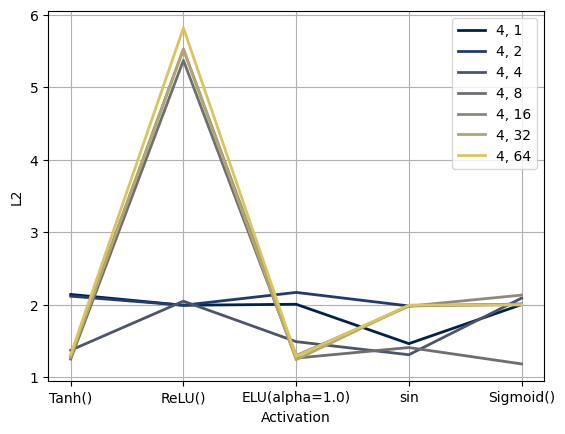

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import numpy as np

# Разделение данных на списки для построения графиков
activations = list(set(activation for activation, _, _ in l2_norms.keys()))
layers_num = list(sorted(set(layer for _, layer, _ in l2_norms.keys())))
neurons_num = list(sorted(set(neuron for _, _, neuron in l2_norms.keys())))


color_cycle = plt.cm.cividis(np.linspace(0, 1, len(layers_num)))
plt.gca().set_prop_cycle(cycler('color', color_cycle))

# for activation in activations:
layers = layers_num[3]
for neurons in neurons_num:
    l2_value = []
    for activation in activations:
        l2_value.append(l2_norms[(activation, layers, neurons)])

    plt.plot([str(activation) for activation in activations], l2_value, label=f'{layers}, {neurons}', linewidth=2)
plt.xlabel('Activation')
plt.ylabel('L2')
plt.legend()
plt.grid(True)
plt.show()